# Байесовский классификатор

Байесовский классификатор — это метод классификации, основанный на применении теоремы Байеса с некоторыми предположениями о независимости признаков. Он используется для решения задач классификации, в частности, для фильтрации спама в электронных сообщениях.

<h2 style="text-align: center;">Теоретическая основа</h2>

### Теорема Байеса

Теорема Байеса описывает, как обновлять вероятность гипотезы, основываясь на новых данных. Формула выглядит следующим образом:

$$
P(C_k | x) = \frac{P(x | C_k) \cdot P(C_k)}{P(x)}
$$

где:

- $P(C_k | x)$ — апостериорная вероятность класса $C_k$, при условии признака $x$.
- $P(x | C_k)$ — правдоподобие (likelihood), то есть вероятность наблюдения признака $x$, при условии, что он принадлежит классу $C_k$.
- $P(C_k)$ — априорная вероятность класса $C_k$.
- $P(x)$ — маргинальная вероятность признака $x$.

### Наивный Байесовский классификатор

Наивный Байесовский классификатор предполагает, что все признаки в каждом классе независимы друг от друга. Это упрощает вычисления и позволяет использовать формулу:

$$
P(C_k | x_1, x_2, \ldots, x_n) = \frac{P(C_k) \cdot \prod_{i=1}^n P(x_i | C_k)}{P(x)}
$$

где:



- $P(C_k | x_1, x_2, \ldots, x_n)$ — апостериорная вероятность класса $C_k$ при условии признаков $x_1, x_2, \ldots, x_n$.
- $P(C_k)$ — априорная вероятность класса $C_k$.
- $P(x_i | C_k)$ — вероятность признака $x_i$, при условии, что он принадлежит классу $C_k$.
- $P(x)$ — маргинальная вероятность признака $x$, которая является нормирующим коэффициентом.


**Логарифмы для численной стабильности**:
   - В реализации Байесовского классификатора логарифмы вероятностей используются для избежания переполнения чисел и улучшения стабильности вычислений. Вычисления в логарифмическом пространстве также позволяют упростить умножение вероятностей в произведение сумм логарифмов.

$$
\log P(C_k | x_1, x_2, \ldots, x_n) = \log P(C_k) + \sum_{i=1}^n \log P(x_i | C_k) - \log P(x)
$$

$P(x)$ — это нормирующий коэффициент, его значение не влияет на относительные вероятности, только на их масштабирование.

Так как $\log P(x)$ является константой для данного текста и не зависит от класса, его можно игнорировать при сравнении вероятностей классов:

$$
P(C_{spam}) = \frac{\exp(\log P(C_{spam}) + \sum_{i=1}^n \log P(x_i | C_{spam}))}{\exp(\log P(C_{spam}) + \sum_{i=1}^n \log P(x_i | C_{spam})) + \exp(\log P(C_{ham}) + \sum_{i=1}^n \log P(x_i | C_{ham}))}
$$

##### Почему мы должны поделить ${\exp(\log P(C_{spam}) + \sum_{i=1}^n \log P(x_i | C_{spam}))}$ на ${\exp(\log P(C_{spam}) + \sum_{i=1}^n \log P(x_i | C_{spam})) + \exp(\log P(C_{ham}) + \sum_{i=1}^n \log P(x_i | C_{ham}))}$, если в изначальной формуле у нас нет речи о делении: $\log P(C_k | x_1, x_2, \ldots, x_n) = \log P(C_k) + \sum_{i=1}^n \log P(x_i | C_k) - \log P(x)$ ?
- Без деления мы получим просто значения, которые пропорциональны вероятностям, но не являются вероятностями в строгом смысле, так как их сумма не равна 1.
- С делением на сумму экспонент логарифмов мы гарантируем, что полученные вероятности нормированы, и их сумма равна 1. Это делает их валидными вероятностями в контексте классификации.

Таким образом, конечный результат представляет собой вероятность того, что текст относится к классу спам.


<h2 style="text-align: center;">Практическая часть</h2>



### Импорт библиотек

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


### Загрузка данных

Мы загружаем данные и обрабатываем их:

In [96]:
data = pd.read_csv("spam.csv", encoding="latin-1")
data.drop(data.iloc[:, 2:5], inplace=True, axis=1)
data.rename(columns={"v1":"class", "v2":"text"}, inplace=True)
data


,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...



### Визуализация классов


<Axes: ylabel='count'>

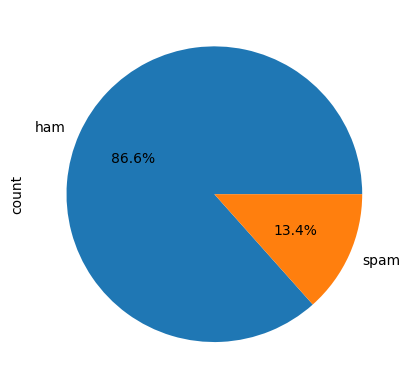

In [97]:
data['class'].value_counts().plot.pie(autopct="%1.1f%%")

Заметим дисбаланс в наших данных.

Если учесть следующий шаг: 
```Python
self.p_spam = 0.134  # Вероятность появления сообщений класса спам = 13.4%
self.p_ham = 0.866  #  Вероятность появления сообщений класса не спам = 86.6%
```
То априорные вероятности будут влиять на классификацию: при большом количестве "ham" сообщений классификатор будет более склонен считать новые сообщения не спамом (если сообщений "ham" значительно больше, модель будет понимать, что "ham" — это более вероятный класс.).


Но мы оставим значения по умолчанию:
```Python
self.p_ham = 0.5
self.p_spam = 0.5
```
Потому что мы хотим, чтобы модель одинаково серьёзно относилась к обеим категориям. Такой подход заставит модель не игнорировать спам (=редкий класс) и не будет делать явных предположений на основе того, что большинство сообщений — не спам. Таким образом, мы делаем пропуск спама более критичным.


### Разделение данных на обучающую и тестовую выборки


In [98]:
x = data['text']
y = data['class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


### Реализация Байесовского классификатора


Пара слов о CountVectorizer:

с помощью метода CountVectorizer, строится словарь (матрица частот слов) и подсчитываются вероятности появления каждого слова для класса спам и не спам. Эти вероятности $P(x_i | C_{spam})$ и $P(x_i | C_{ham})$ получаются как отношение числа появлений слова к общему числу слов в спаме или не спаме. Мы также используем сглаживание Лапласа, чтобы избежать нулевых вероятностей, добавляя `alpha` к каждому счёту.

In [99]:
class BayesianClassifier:
    def __init__(self, alpha=1):
        """
        alpha - сглаживающий параметр Лапласа (по умолчанию 1).
        """
        self.words = {}
        self.p_ham = 0.5
        self.p_spam = 0.5
        self.alpha = alpha  # Параметр Лапласа (используется для сглаживания вероятностей слов, чтобы избежать нулевых вероятностей.)

    def fit(self, texts, labels, token_pattern=r"(?u)\b\w\w+\b"):
        """
        texts - список текстов для обучения.
        labels - метки классов (спам/хам).
        token_pattern - регулярное выражение для извлечения токенов (по умолчанию слова из 2+ букв).
        """
        # Подсчёт вероятностей классов
        label_counts = labels.value_counts(normalize=True)
        self.p_spam = label_counts.get('spam', 0.5)
        self.p_ham = 1 - self.p_spam

        # Векторизация текстов
        vectorizer = CountVectorizer(token_pattern=token_pattern)
        x = vectorizer.fit_transform(texts).toarray()
        self.words = vectorizer.get_feature_names_out()
        
        # Разделение на спам/хам тексты
        spam_texts = x[np.array(labels) == 'spam']
        ham_texts = x[np.array(labels) == 'ham']
        
        # Подсчет вероятностей слов в спаме и хаме с Лапласовым сглаживанием
        spam_word_counts = np.sum(spam_texts, axis=0) + self.alpha
        ham_word_counts = np.sum(ham_texts, axis=0) + self.alpha
        total_spam_words = np.sum(spam_word_counts)
        total_ham_words = np.sum(ham_word_counts)
        
        # Вероятности слов для каждого класса
        self.word_prob_spam = spam_word_counts / total_spam_words
        self.word_prob_ham = ham_word_counts / total_ham_words

    def spam_text(self, text):
        """
        text - текст для классификации.
        Возвращает вероятность того, что текст является спамом.
        """
        v = CountVectorizer(vocabulary=self.words)
        x = v.transform([text]).toarray()[0]

        # Логарифмы вероятностей для численной стабильности
        log_p_spam = np.log(self.p_spam)
        log_p_ham = np.log(self.p_ham)

        for i, word_count in enumerate(x):
            if word_count > 0:
                log_p_spam += word_count * np.log(self.word_prob_spam[i])
                log_p_ham += word_count * np.log(self.word_prob_ham[i])

        # Вероятность того, что текст - спам (по правилу Байеса)
        return np.exp(log_p_spam) / (np.exp(log_p_spam) + np.exp(log_p_ham))

    def check(self, texts, labels):
        """
        texts - список текстов для проверки.
        labels - истинные метки классов.
        Вычисляет accuracy (точность) и confusion matrix.
        """
        predictions = [self.spam_text(text) > 0.5 for text in texts]
        true_labels = np.array(labels) == 'spam'
        
        # Преобразование `predictions` и `true_labels` в булевы массивы
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)

        tp = np.sum((predictions == True) & (true_labels == True))  # True Positives
        tn = np.sum((predictions == False) & (true_labels == False))  # True Negatives
        fp = np.sum((predictions == True) & (true_labels == False))  # False Positives
        fn = np.sum((predictions == False) & (true_labels == True))  # False Negatives

        confusion_matrix = np.array([[tp, fp], [fn, tn]])

        accuracy = (tp + tn) / len(labels)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return confusion_matrix, accuracy, precision, recall, f1



### Создадим и обучим модель

In [100]:
bc = BayesianClassifier()
bc.fit(x_train, y_train)

### Получим оценки метрик

In [102]:
confusion_matrix, accuracy, precision, recall, f1 = bc.check(x_test, y_test)

print("Confusion Matrix:\n", confusion_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Confusion Matrix:
 [[136   1]
 [  9 969]]
Accuracy: 0.9910313901345291
Precision: 0.9927007299270073
Recall: 0.9379310344827586
F1-score: 0.9645390070921986


### Пример работы на наших новых данных

In [103]:
# Спамовые сообщения
spam_texts = [
    "Congratulations! You've won a $1000 gift card. Call now to claim your prize.",
    "Dear user, your account has been compromised. Click the link to verify your details.",
    "Win a free vacation by entering our sweepstakes. No purchase necessary."
]

# Не спамовые сообщения
ham_texts = [
    "Hello, how are you?",
    "Let's meet for lunch",
    "Reminder: Your doctor's appointment is scheduled for next Monday at 2 PM.",
    "Can you send me the latest version of the presentation? Thanks!"
]

print("Spam probability:")
for text in spam_texts:
    print(bc.spam_text(text))

print("\nHam probability:")
for text in ham_texts:
    print(bc.spam_text(text))

Spam probability:
0.9999999981190751
0.9991243336510646
0.9903320439742952

Ham probability:
0.0005856311114311154
0.001217586361458292
0.013246221555832945
0.0016451627410237766
